# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np
import json
from scipy import stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine learning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

# Ignore all future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create columns `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create columns `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created columns for paper `P17`.
- Print the resulting dataframe.

First, we check how the input data is given so we know how to process it. We ssume scores before and after have more or less the same format.
Loading JSON:

In [2]:
acl_reviews = pd.read_json('data/acl18_v1_numerical_final.json')
# check type
print(type(acl_reviews))  
acl_reviews.head()

<class 'pandas.core.frame.DataFrame'>


,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True


In [3]:
# This is to see the info that is currently held
print(type(acl_reviews.iloc[0]['scores_before']))
acl_reviews.iloc[0]['scores_before']

<class 'dict'>


{'2': {'scores': {'originality': 2,
   'soundness_correctness': 4,
   'substance': 4,
   'replicability': 4,
   'meaningful_comparison': 4,
   'readability': 4,
   'overall_score': 2},
  'contributions': {'nlp_tasks_applications': 'Marginal contribution',
   'methods_algorithms': None,
   'theoretical_algorithmic_results': None,
   'empirical_results': None,
   'data_resources': None,
   'software_systems': None,
   'evaluation_methods_metrics': None},
  'checks': {'appropriateness': 'Appropriate',
   'adhere_to_acl_2018_guidelines': 'Yes',
   'adhere_to_acl_author_guidelines': 'Yes',
   'handling_of_data_resources': None,
   'handling_of_human_participants': None}},
 '3': {'scores': {'originality': 4,
   'soundness_correctness': 2,
   'substance': 2,
   'replicability': 4,
   'meaningful_comparison': 2,
   'readability': 3,
   'overall_score': 3},
  'contributions': {'nlp_tasks_applications': 'Moderate contribution',
   'methods_algorithms': 'Moderate contribution',
   'theoretical_al

So the format is that it is a nested dictionary in python, and what we need to do is extract the number of reviews, and for each review get the overall_score value.

Let's create a function to obtain the desired metric over the overall score on the JSON for every row of data for column col

In [4]:
def get_metric_of_overall_score(data,col, metric):
    averaged_array = []
    paper_array = []
    for json in data[col]:
        for key, value in json.items():
            paper_array.append(value['scores']['overall_score'])
        averaged_array.append(metric(paper_array))
        paper_array = []
    return averaged_array

Let's get average and std before and after the rebuttal and assign them to the respective columns

In [5]:
acl_reviews['overall_score_before_avg'] = get_metric_of_overall_score(acl_reviews,'scores_before',np.mean)
acl_reviews['overall_score_after_avg'] = get_metric_of_overall_score(acl_reviews,'scores_after',np.mean)
acl_reviews['overall_score_before_std'] = get_metric_of_overall_score(acl_reviews,'scores_before',np.std)
acl_reviews['overall_score_after_std'] = get_metric_of_overall_score(acl_reviews,'scores_after',np.std)
acl_reviews

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.333333,2.333333,0.471405,0.471405
1541,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.816497,0.816497
1542,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,2.666667,0.942809,0.942809
1543,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.000000,0.000000


In [6]:
# this function does the same as get_metric_of_overall_score but using pre built functions, it's an alternative
"""def result_processing_scores(row) -> list:
    resulting_values_before = []
    for key in row['scores_before']:
        resulting_values_before.append(row['scores_before'][key]['scores']['overall_score'])

    resulting_values_after = []
    for key in row['scores_after']:
        resulting_values_after.append(row['scores_after'][key]['scores']['overall_score'])


    return [np.mean(resulting_values_before), np.mean(resulting_values_after),
            np.std(resulting_values_before), np.std(resulting_values_after)]
# In pandas.apply, I can use result_type = 'expand' to transform it into what I need to change!
temp_df = acl_reviews.apply(result_processing_scores, axis=1, result_type='expand')
temp_df.columns = ['overall_score_before_avg', 'overall_score_after_avg',
                   'overall_score_before_std', 'overall_score_after_std']

# This is the newly created paper!
acl_reviews = pd.concat([acl_reviews, temp_df], axis=1)"""

"def result_processing_scores(row) -> list:\n    resulting_values_before = []\n    for key in row['scores_before']:\n        resulting_values_before.append(row['scores_before'][key]['scores']['overall_score'])\n\n    resulting_values_after = []\n    for key in row['scores_after']:\n        resulting_values_after.append(row['scores_after'][key]['scores']['overall_score'])\n\n\n    return [np.mean(resulting_values_before), np.mean(resulting_values_after),\n            np.std(resulting_values_before), np.std(resulting_values_after)]\n# In pandas.apply, I can use result_type = 'expand' to transform it into what I need to change!\ntemp_df = acl_reviews.apply(result_processing_scores, axis=1, result_type='expand')\ntemp_df.columns = ['overall_score_before_avg', 'overall_score_after_avg',\n                   'overall_score_before_std', 'overall_score_after_std']\n\n# This is the newly created paper!\nacl_reviews = pd.concat([acl_reviews, temp_df], axis=1)"

Since we will only use the overall score for the homework, we can remove the nested JSON columns

In [7]:
acl_reviews = acl_reviews.drop('scores_before', axis=1)
acl_reviews = acl_reviews.drop('scores_after', axis=1)
acl_reviews

,tmp_id,status,submission_type,track,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,True,3.000000,2.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,True,2.333333,2.333333,0.471405,0.471405
1541,P1542,Reject,Long,Machine Learning,False,2.000000,2.000000,0.816497,0.816497
1542,P1543,Reject,Long,Machine Learning,True,2.666667,2.666667,0.942809,0.942809
1543,P1544,Reject,Short,Social Media,False,2.000000,2.000000,0.000000,0.000000


Let's visualise our new metric columns for 'P17'

In [8]:
# Also printing the tmp id to show that it's correct or not!
display(acl_reviews[acl_reviews['tmp_id'] == 'P17'][['tmp_id','overall_score_before_avg', 'overall_score_after_avg',
                                             'overall_score_before_std', 'overall_score_after_std']])

,tmp_id,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
16,P17,4.5,4.5,0.5,0.5


Display of the resulting DF

In [9]:
# Printing the resulting DF
display(acl_reviews)

,tmp_id,status,submission_type,track,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,True,3.000000,2.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,True,2.333333,2.333333,0.471405,0.471405
1541,P1542,Reject,Long,Machine Learning,False,2.000000,2.000000,0.816497,0.816497
1542,P1543,Reject,Long,Machine Learning,True,2.666667,2.666667,0.942809,0.942809
1543,P1544,Reject,Short,Social Media,False,2.000000,2.000000,0.000000,0.000000


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

We're not sure on what type of plot is wanted, but we think both a histogram and a box plot are helpful. So we will plot both of these

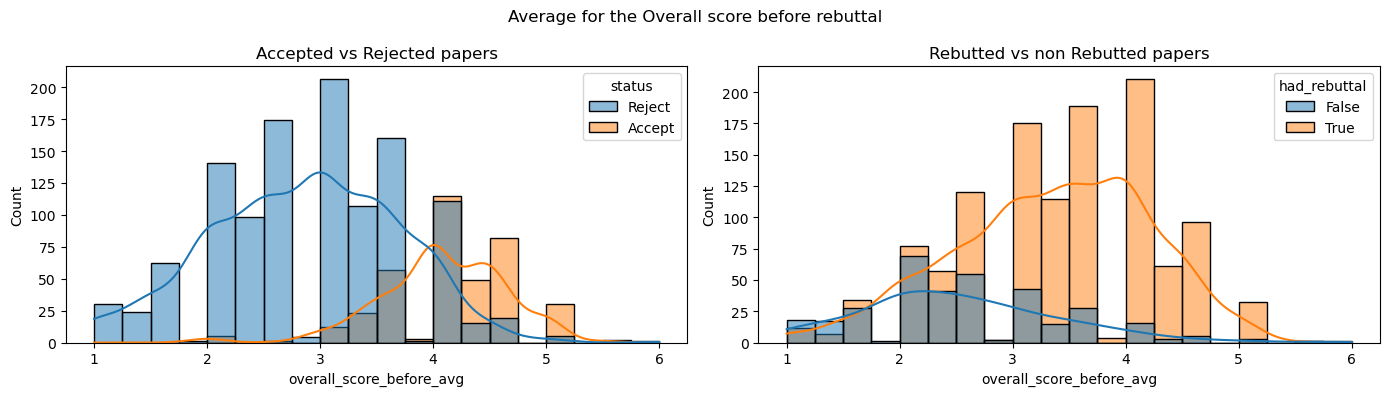

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)) 
fig.suptitle('Average for the Overall score before rebuttal')

# Panel A
sns.histplot(acl_reviews, x='overall_score_before_avg', hue='status', kde=True, color='blue', ax=axs[0])
axs[0].set_title('Accepted vs Rejected papers')

# Panel B
sns.histplot(acl_reviews, x='overall_score_before_avg', hue='had_rebuttal', kde=True, color='blue', ax=axs[1])
axs[1].set_title('Rebutted vs non Rebutted papers')

plt.tight_layout()
plt.show()

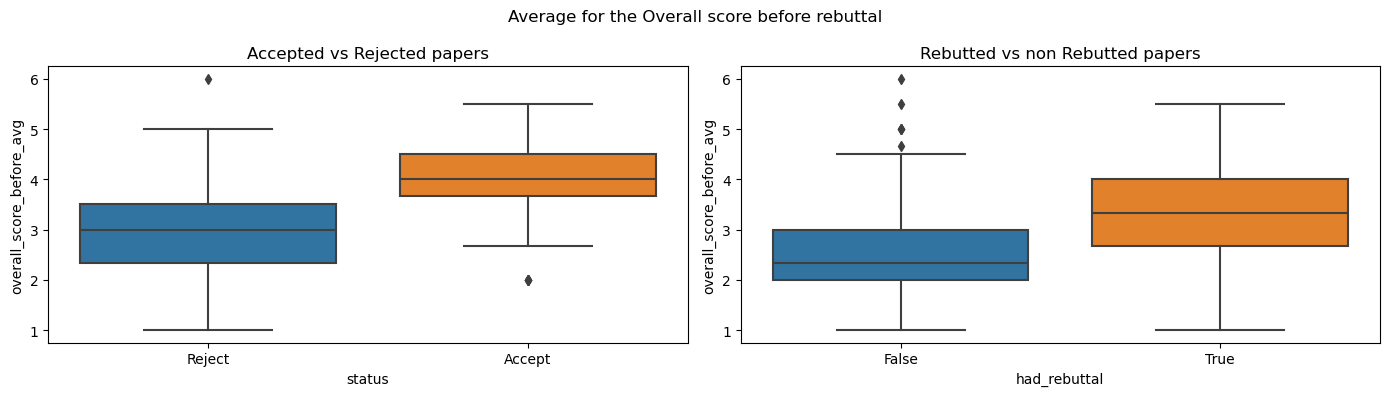

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Average for the Overall score before rebuttal')

# Panel A
sns.boxplot(acl_reviews, x='status', y='overall_score_before_avg', ax=axs[0])
axs[0].set_title('Accepted vs Rejected papers')

# Panel B
sns.boxplot(acl_reviews, x='had_rebuttal', y='overall_score_before_avg', ax=axs[1])
axs[1].set_title('Rebutted vs non Rebutted papers')

plt.tight_layout()
plt.show()

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

<span style="color:lime">Answer: </span>

For this case, we'll assume we aren't meant to do additional statistical tests or anything of the sort, and that we should answer the question with only the information we have processed. We will assume that the rest of the homework will focus on properly answering this question or not.

There is not enough information to to say whether rebuttals help papers get accepted. There could be a confounder - for example, if an author receives a low average score, he may think that he doesn't have a chance of getting accepted and therefore doesn't bother writing a rebuttal.

In the histogram Panel A - Acceptance vs. Rejection: In Panel A, the distribution of scores before a rebuttal for papers that were eventually accepted is more shifted to the right than those without rebuttals. This suggests that papers with higher initial scores are more likely to be accepted. However, without knowing the after-rebuttal scores, we cannot conclude whether rebuttals contribute to the acceptance.

In the histogram Panel B - Rebuttal vs. No Rebuttal: In Panel B, we see that papers that had a rebuttal tend to have higher scores before the rebuttal than those without a rebuttal. This could indicate that papers with rebuttals were initially of higher quality or that the possibility of a rebuttal is more likely when scores are borderline and a decision is not clear-cut.

If we know a paper had a rebuttal, based on Panel B, it is more likely that it had a higher initial score, which correlates with a higher likelihood of acceptance as seen in Panel A. However, whether rebuttals help papers get accepted cannot be directly inferred without further analyzing the data. For example, in this analysis we have assumed that the distributions are indeed shifted to the right, and we would need to prove that, not just speculate about it based on the graphs. We could calculate the p-value to test the null hypothesis of both cases having the same mean (i.e. the mean average score is the same for rejected/accepted papers, or papers with/without)

We can also see in the box plots that we cannot properly answer this. In both panels, while the means are different, the confidence intervals overlap. So we do not properly know if there is a difference or now.

Another reason that a paper is without rebuttal is that the score is very high. If it's essentially perfect and doesn't need any clarifications or have any concerns to address, an author may not be compelled to write a rebuttal. This means that the rebuttal has no effect on the paper getting accepted.

So far, we have just analyzed whether a paper with rebutal is more likely to get accepted. We still need to talk about whether rebuttals help papers get accepted. Let's see why we don't believe that rebuttals help papers get accepted with a concrete example:

Suppose a paper received a score of 3 before rebuttal and was accepted after the rebuttal process. This single instance does not provide conclusive evidence that the rebuttal caused the paper to be accepted, as we don't know if the score improved after the rebuttal. It could be that the paper was on the borderline of acceptance and the rebuttal clarified doubts, leading to acceptance. Conversely, a paper might have a high initial score and still be rejected after a rebuttal if the rebuttal fails to address the reviewers' concerns.

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [12]:
# First, we group by track. The column "had_rebuttal" is binary, so we can take an average per track
rebuttal_percentage = acl_reviews.groupby('track')['had_rebuttal'].mean()
# Format with the '%' symbol and round to 2 decimal places
rebuttal_percentage_formatted = (rebuttal_percentage * 100).round(2).astype(str) + '%'
display(rebuttal_percentage_formatted)

track
Dialogue and Interactive Systems                                77.53%
Discourse and Pragmatics                                        80.43%
Document Analysis                                                73.0%
Generation                                                      77.97%
Information Extraction and Text Mining                          76.84%
Linguistic Theories Cognitive Modeling and Psycholinguistics     75.0%
Machine Learning                                                80.87%
Machine Translation                                             82.08%
Multidisciplinary and Area Chair COI                             68.0%
Multilinguality                                                 80.65%
Phonology Morphology and Word Segmentation                      85.19%
Question Answering                                              72.84%
Resources and Evaluation                                        73.24%
Sentence-level semantics                                        78.89%


<span style="color:lime">Answer: </span>

When comparing two groups in hypothesis testing, we typically use the t-test. To compare 3 or more groups, we can use ANOVA (Analysis of Variance). Similar to the t-test, with ANOVA we can compare means across multiple groups to determine if there are statistically significant differences among them,  if the data follows a normal distribution.

To decide if all tracks have the same fraction of papers with rebuttals, we formulate our hypotheses:
Null Hypothesis (H0): The means of all groups are equal (all tracks have the same fraction of papers with rebuttals, f1=f2=f3=...=fn)
Alternative Hypothesis (H1): At least one group's mean is different (at least one track has a different fraction of papers with rebuttals, Exists at least one pair of i,j such that fi!=fj where i!=j)

Decide on the level of significance (probability of making a Type I error). A typical value is 0.05.

If the p-value is less than the chosen significance level, we reject the null hypothesis, indicating that we have to dig deeper in order to understand your data, as maybe the mean of one or more group is different to the others.

If the p-value is greater than or equal to the significance level, we cannot reject the null hypothesis, indicating no significant differences among the groups.

For a more thorough approach, we could create a linear mixed model with paper acceptance as the dependent variable, and the track as the independent variable. That way we have a better idea of how big the difference is, and how certain we are about this fact.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [13]:
dummies = pd.get_dummies(acl_reviews['track'])
dummies = dummies.rename(columns=lambda x: f'{x}-onehot')

# Change values to 1 and 0
dummies = dummies.astype(int)

acl_reviews = pd.concat([acl_reviews, dummies], axis=1)

# Print column names of resulting data frame
display(acl_reviews.columns)

Index(['tmp_id', 'status', 'submission_type', 'track', 'had_rebuttal',
       'overall_score_before_avg', 'overall_score_after_avg',
       'overall_score_before_std', 'overall_score_after_std',
       'Dialogue and Interactive Systems-onehot',
       'Discourse and Pragmatics-onehot', 'Document Analysis-onehot',
       'Generation-onehot', 'Information Extraction and Text Mining-onehot',
       'Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot',
       'Machine Learning-onehot', 'Machine Translation-onehot',
       'Multidisciplinary and Area Chair COI-onehot', 'Multilinguality-onehot',
       'Phonology Morphology and Word Segmentation-onehot',
       'Question Answering-onehot', 'Resources and Evaluation-onehot',
       'Sentence-level semantics-onehot',
       'Sentiment Analysis and Argument Mining-onehot', 'Social Media-onehot',
       'Summarization-onehot', 'Tagging Chunking Syntax and Parsing-onehot',
       'Textual Inference and Other Areas of Semantics-on


**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [14]:
acl_reviews['had_rebuttal_int'] = acl_reviews['had_rebuttal'].astype('int')
acl_reviews['accepted_int'] = (acl_reviews['status']=='Accept').astype('int')

Once again, when accepted and rebuttal numerical columns are created, it would make sense to remove them from the DataFrame

In [15]:
acl_reviews.drop(['had_rebuttal','status'],axis=1,inplace=True)
acl_reviews

,tmp_id,submission_type,track,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std,Dialogue and Interactive Systems-onehot,Discourse and Pragmatics-onehot,Document Analysis-onehot,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
0,P1,Long,Machine Learning,2.500000,2.500000,0.500000,0.500000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,P2,Long,Question Answering,3.333333,3.333333,0.942809,0.942809,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,P3,Short,Multidisciplinary and Area Chair COI,4.666667,4.666667,0.471405,0.471405,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,P4,Short,Machine Learning,3.000000,2.666667,0.816497,1.247219,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,P5,Long,Document Analysis,3.000000,2.500000,0.000000,0.500000,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,P1541,Short,Textual Inference and Other Areas of Semantics,2.333333,2.333333,0.471405,0.471405,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1541,P1542,Long,Machine Learning,2.000000,2.000000,0.816497,0.816497,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1542,P1543,Long,Machine Learning,2.666667,2.666667,0.942809,0.942809,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1543,P1544,Short,Social Media,2.000000,2.000000,0.000000,0.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0


**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [16]:
def numpy_helper(df, cols):
    return np.array(df.loc[:,cols], dtype = float)

Let's try that is working

In [17]:
arr = numpy_helper(acl_reviews,['overall_score_before_avg', 'overall_score_after_avg',
       'overall_score_before_std', 'overall_score_after_std'])
arr

array([[2.5       , 2.5       , 0.5       , 0.5       ],
       [3.33333333, 3.33333333, 0.94280904, 0.94280904],
       [4.66666667, 4.66666667, 0.47140452, 0.47140452],
       ...,
       [2.66666667, 2.66666667, 0.94280904, 0.94280904],
       [2.        , 2.        , 0.        , 0.        ],
       [3.        , 3.        , 0.81649658, 0.81649658]])


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

Getting X features

In [18]:
target_features = list(dummies.columns) + ['overall_score_before_avg', 'overall_score_before_std', 'had_rebuttal_int']
acl_X = numpy_helper(acl_reviews, target_features)

Getting y feature

In [19]:
# We flatten the y so that it works properly with the later steps
# If not, the return shape is by default (n,1), when we want just (n,)
acl_y = numpy_helper(acl_reviews, ['accepted_int']).flatten()

Shapes

In [20]:
print('Shape of X features:', acl_X.shape)
print('Shape of y outcomes:', acl_y.shape)

Shape of X features: (1538, 24)
Shape of y outcomes: (1538,)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [21]:
# model
gradient_boost_model = GradientBoostingClassifier()

### Model 1

In [22]:
# It's easier to just give the model directly into the cross_validate method
# The only important detail is that we have to create a separate dataset for model 1
# as it's easier than filtering the relevant columns
model_1_features = list(dummies.columns) + ['overall_score_before_avg', 'overall_score_before_std']
acl_X_model_1 = numpy_helper(acl_reviews, model_1_features)

In [23]:
model_1_res = cross_validate(gradient_boost_model, acl_X_model_1, acl_y, cv=30, scoring=('accuracy', 'precision', 'recall'))

Results

In [24]:
print('Precision (fraction of positive predictions that are actually positive): ', model_1_res['test_precision'].mean(), 
      '\nRecall (fraction of actually positive examples that we recognized as such): ', model_1_res['test_recall'].mean(), 
      '\nAccuracy (fraction of correct classifications): ', model_1_res['test_accuracy'].mean())

Precision (fraction of positive predictions that are actually positive):  0.7085207385207386 
Recall (fraction of actually positive examples that we recognized as such):  0.592948717948718 
Accuracy (fraction of correct classifications):  0.8373303167420816


### Model 2

In [25]:
# cross_validate takes care of pretty much everything, so we can just run it with the
# data and analyze the data afterwards
model_2_res = cross_validate(gradient_boost_model, acl_X, acl_y, cv=30, scoring=('accuracy', 'precision', 'recall'))

Results

In [26]:
print('Precision (fraction of positive predictions that are actually positive): ', model_2_res['test_precision'].mean(), 
      '\nRecall (fraction of actually positive examples that we recognized as such): ', model_2_res['test_recall'].mean(), 
      '\nAccuracy (fraction of correct classifications): ', model_2_res['test_accuracy'].mean())

Precision (fraction of positive predictions that are actually positive):  0.7126813001813002 
Recall (fraction of actually positive examples that we recognized as such):  0.5957264957264959 
Accuracy (fraction of correct classifications):  0.8386500754147814



**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [27]:
# We set the null hypothesis of both models having the same accuracy
# We set a significance level of 0.05, so if the p-value is larger than that, we cannot reject the null hypothesis
stats.ttest_ind(model_1_res['test_accuracy'], model_2_res['test_accuracy'])

TtestResult(statistic=-0.1291661307585383, pvalue=0.897673080747567, df=58.0)

As the p-value is 0.898, larger than 0.05, we cannot reject the null hypothesis of both models having the same accuracy. Thus we conclude that there is not a statistically significant difference in the accuracy of both models.

\* Addendum \* <br>
* We don't want to assume that the underlying data is normally distributed, so we will avoid using the t-test and instead use the wilcoxon statistical test

In [28]:
from scipy.stats import wilcoxon

print("Difference in accuracy:", wilcoxon(model_1_res['test_accuracy'], model_2_res['test_accuracy']))

Difference in accuracy: WilcoxonResult(statistic=14.0, pvalue=0.5686937049334944)


The result has a high p value. Based on this fact, the difference in accuracy between the two models is not statistically significant.

**2.7** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

<span style="color:lime">Answer: </span>

The advantage of 2.6 is that it allows us to test whether having a rebuttal gives significant improvement when predicting whether a paper gets accepted. However, we could not show statistical significane, so we still do not know if there is a causal connection.

In Task 1, we observed the distribution of scores for accepted vs rejected papers, as well as the distribution of scores for papers with/without a rebuttal. This was not enough to make a causal connection either.

It is important to remark that this is still not enough to show causation. There could be a correlation between paper acceptance and having a rebuttal, perhaps if authors with high initial scores believed they had a chance at acceptance and thus invested effort into writing a rebuttal.

Our analyses only show that had_rebuttal did not give significant model improvement. There still could be another confounder, for example the score after rebuttal. This could tell us if the rebuttal help increase the score or not. 

Additionally, the feature being useful or not with a gradient boosted classifier is not easily statistically interpretable, as we do not know whether it had a weight or not. Add how the trained system might not have a good accuracy and general, and our results here are suspect as a minimum.


## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regressions. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [29]:
ols1 = smf.ols('accepted_int ~ had_rebuttal_int', data=acl_reviews).fit()
ols2 = smf.ols('accepted_int ~ overall_score_after_avg', data=acl_reviews).fit()
ols3 = smf.ols('had_rebuttal_int ~ overall_score_before_avg', data=acl_reviews).fit()

display(ols1.summary())
display(ols2.summary())
display(ols3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.24e-16
Time:                        23:45:59   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0838      0.023      3.693      0.000       0.039       0.128
had_rebuttal_int     0.2098      0.026      8.138      0.000       0.159       0.260
==============================================================================
Omnibus:                      271.753   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.377
Skew:                           1.075   Prob(JB):                     3.65e-71
Kurtosis:                       2.336   Cond. No.                         4.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          1.58e-173
Time:                        23:45:59   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6558      0.029    -22.339      0.000      -0.713      -0.598
overall_score_after_avg     0.2860      0.009     32.111      0.000       0.269       0.303
==============================================================================
Omnibus:                      110.778   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.680
Skew:                           0.256   Prob(JB):                     5.99e-12
Kurtosis:                       2.263   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.89e-50
Time:                        23:45:59   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2527      0.035      7.195      0.000       0.184       0.322
overall_score_before_avg     0.1651      0.011     15.499      0.000       0.144       0.186
==============================================================================
Omnibus:                      201.621   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.526
Skew:                          -1.060   Prob(JB):                     2.23e-63
Kurtosis:                       2.890   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variable in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



<span style="color:lime">Answer: </span>

Model 1: `accepted_int ~ had_rebuttal_int`,  
- **Coefficient**: The presence of a rebuttal would increase the likelihood of being accepted by 0.21 (we rounded to two decimals). 

Model 2: `accepted_int ~ overall_score_after_avg`
- **Coefficient**: For any one-unit increase in the average of the overall score, the likelihood of a paper to get accepted increases by 0.29. 

Model 3: `had_rebuttal_int ~ overall_score_before_avg`
- **Coefficient**: A one-unit increase in the overall score before the review would lead to a 0.17 increase in the likelihood of having a rebuttal.


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


<span style="color:lime">Answer: </span>

Model 1: `accepted_int ~ had_rebuttal_int`,  
- **Sign**: Positive, so having a rebuttal is correlated wth being accepted.
- **Significance**: Statistically Significant. The p-value is well below 0.05.

Model 2: `accepted_int ~ overall_score_after_avg`
- **Sign**: Positive, so the avg overall score after rebuttal is correlated with being accepted.
- **Significance**: Statistically Significant. The p-value is well below 0.05.


Model 3: `had_rebuttal_int ~ overall_score_before_avg`
- **Sign**: Positive, so the avg overall score before rebuttal is correlated with having a rebuttal.
- **Significance**: Statistically Significant. The p-value is well below 0.05.

It is important to note that all of these results have a low Adjusted R squared, so while there is a correlation it is not that precise. It is also worth noting that the model with the highest Adjusted R squared is 'Accepted - Overall Score after Average'

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


<span style="color:lime">Answer: </span>

Yes, it's True because the  R-squared:                       0.402
                 Adj. R-squared:                  0.401
            is higher at `overall_score_after_avg`
than in `overall_score_before_avg`
                 R-squared:                       0.135
                 Adj. R-squared:                  0.135

The regular R-squared measures the proportion of the variance in the dependent variable that is explained by the independent variables in the model, it is used to explain the variance, the lower value tells us that it explains less of it.


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

<span style="color:lime">Answer: </span>

- Sa->Ac
- Sb->Sa
- Sb->Re
- Sb-> Ac
- Re->Ac
- Re->Sa
- Tr->Sa
- Tr->Sb
- Tr->Re
- Tr->Ac

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

<span style="color:lime">Answer: </span>

There are other covariates that affect outcome of paper and rebuttals at the same time. This ignores the possible causal relationship between Sb->Ac, Sb->Re, and Sb->Ac. As explained before, for example, a paper that is close to having a score that would get accepted is more likely to attempt rebuttal that a paper with a lower score. In 1.2 we saw that papers that had rebuttals have a higher overall_score_before_avg, according to the graph, as the distribution is more shifted towards higher scores.

In other words, as paper with higher scores are more likely to have rebuttals, they are also more likely to be accepted. Therefore, higher scores affect both rebuttals and outcome. It is still possible that rebuttals have no effect on the outcome.

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [30]:
# Reset the index to avoid errors in the graph construction
acl_reviews.reset_index(inplace=True) 

# Separate the treatment and control groups
treatment_df = acl_reviews[acl_reviews['had_rebuttal_int'] == 1]
control_df = acl_reviews[acl_reviews['had_rebuttal_int'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
         # Given the instruction of the exact matching, we only add an edge if 
         # the track is the same and if the overall score is the same
        if control_row['track'] == treatment_row['track']:
            if control_row['overall_score_before_avg'] == treatment_row['overall_score_before_avg']:
                G.add_edge(control_id, treatment_id)
        

# Generate and return the maximal matching on the generated graph
matching = nx.maximal_matching(G)

# We create a list with all the indexes of the matched instances
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
matched_df = acl_reviews.iloc[matched]


In [31]:
display(matched_df)

,index,tmp_id,submission_type,track,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std,Dialogue and Interactive Systems-onehot,Discourse and Pragmatics-onehot,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
24,24,P25,Long,Machine Learning,3.000000,3.000000,1.000000,1.000000,0,0,...,0,0,0,0,0,0,0,0,1,0
307,308,P309,Long,Generation,3.000000,2.500000,1.000000,0.500000,0,0,...,0,0,0,0,0,0,0,0,0,0
850,853,P854,Long,Social Media,2.000000,2.000000,0.000000,0.000000,0,0,...,0,0,1,0,0,0,0,0,1,0
709,711,P712,Long,Tagging Chunking Syntax and Parsing,2.666667,2.666667,0.471405,0.471405,0,0,...,0,0,0,0,1,0,0,0,0,0
279,280,P281,Short,Tagging Chunking Syntax and Parsing,2.333333,2.333333,0.471405,0.471405,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,582,P583,Long,Question Answering,2.666667,2.666667,0.471405,0.471405,0,0,...,0,0,0,0,0,0,0,0,0,0
18,18,P19,Long,Tagging Chunking Syntax and Parsing,3.500000,4.000000,0.500000,0.816497,0,0,...,0,0,0,0,1,0,0,0,1,0
657,659,P660,Short,Word-level Semantics,3.500000,3.500000,0.500000,0.500000,0,0,...,0,0,0,0,0,0,0,1,1,0
860,863,P864,Short,Word-level Semantics,2.666667,2.333333,1.247219,0.942809,0,0,...,0,0,0,0,0,0,0,1,1,0


**4.2** So far, we did not consider the `score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [32]:
# separating treatment and control sets
treatment_matched_df = matched_df[matched_df['had_rebuttal_int'] == 1]
control_matched_df = matched_df[matched_df['had_rebuttal_int'] == 0]

# computing the SMD
smd_num = np.abs(treatment_matched_df['overall_score_before_std'].mean() - control_matched_df['overall_score_before_std'].mean())
smd_den = np.sqrt((treatment_matched_df['overall_score_before_std'].std() ** 2 + control_matched_df['overall_score_before_std'].std() ** 2))
smd = smd_num / smd_den
print(smd)


0.04526184975441886


The SMD is around 0.05, which means that the variables are balanced.


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [33]:
ols_matched = smf.ols('accepted_int ~ had_rebuttal_int', data=matched_df).fit()
print(ols_matched.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 1.070e-12
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               1.00
Time:                        23:46:06   Log-Likelihood:                -124.36
No. Observations:                 542   AIC:                             252.7
Df Residuals:                     540   BIC:                             261.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1033      0.019  


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

<span style="color:lime">Answer: </span>

i) 
Now, P>|t| is 1. This indicates that the probability of observing this effect by chance is quite high, so we cannot conclude that rebuttals have an effect on a paper getting accepted. So we do not have enough evidence to reject the null hypothesis that rebuttals have an effect on being accepted.

Results are different from those obtained in Part 1 because now the dataset is balanced. In part 1, most paper that had rebuttals has a higher average score than those which did not, so the chances of acceptance were higher. Additionally there was the effect of other confounding variables, such as different tracks that might have had an effect.

ii)
There is no need to compare the other covariates because we are using a balanced dataset. Here we matched on score before and track to eliminate the confounder possibility through the use of a randomized controlled experiment. We also guaranteed that there is no relation with regards to the standard deviation with the previous result, so we know we don't have to worry about that variable.

In a nutshell: By doing the matching we are taking care of most of the confounders in our simplified dataset. We are technically ignoring other variables, such as index, but we are assuming they can be safely ignored for this analysis.

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac

Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.

Does this uncontrolled confounder threaten the validity of your findings?


<span style="color:lime">Answer: </span>

No, as the conclusion was that we do not know whether rebuttals can effect acceptance. Our conclusion is already that we are unsure, so adding an uncontrolled confounder cannot make us less uncertain.

If we had found that we know rebuttals affect acceptance, then this might threaten the validity of our findings. This is because this is both affecting treatment and outcome variables. We could try and deal with this through a sensitity analysis model to at least try and quantify the importance that this might have.